In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[time:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope = 0.01):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.batch(32).prefetch(1)
    forcast = model.predict(ds)
    return forcast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(52)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
lr_schedular = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedular])

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 39.5042 - mae: 40.0037 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 36.3252 - mae: 36.8245 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 32.5835 - mae: 33.0827 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 28.5319 - mae: 29.0308 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 24.2006 - mae: 24.6987 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 19.7522 - mae: 20.2487 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 15.8283 - mae: 16.3220 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 13.4301 - mae: 13.9203 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 12.5606 - mae: 1

31/31 [==============================] - 0s 9ms/step - loss: 8.3966 - mae: 8.8832 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 10ms/step - loss: 4.6895 - mae: 5.1692 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 11ms/step - loss: 8.3457 - mae: 8.8342 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 11ms/step - loss: 7.9127 - mae: 8.4008 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 12ms/step - loss: 9.4038 - mae: 9.8943 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 13ms/step - loss: 9.0484 - mae: 9.5389 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 9ms/step - loss: 6.3901 - mae: 6.8746 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 9ms/step - loss: 10.9091 - mae: 11.4010 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 7ms/step - loss: 6.8372 - mae: 7.3218 - lr: 1.0000e-0

(1e-08, 0.0001, 0.0, 30.0)

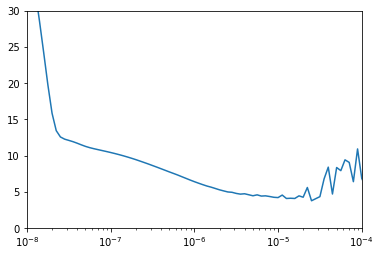

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 5.7152 - mae: 6.1947
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 5.6781 - mae: 6.1584
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 5.5008 - mae: 5.9795
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 5.3523 - mae: 5.8310
Epoch 9/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2824 - mae: 5.7620
Epoch 10/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2310 - mae: 5.7108
Epoch 11/500
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 8ms/step - loss: 4.2967 - mae: 4.7724
Epoch 88/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2213 - mae: 4.6956
Epoch 89/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2231 - mae: 4.6978
Epoch 90/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2350 - mae: 4.7095
Epoch 91/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2431 - mae: 4.7173
Epoch 92/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2444 - mae: 4.7195
Epoch 93/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2195 - mae: 4.6937
Epoch 94/500
31/31 [==============================] - 0s 8ms/step - loss: 4.3017 - mae: 4.7758
Epoch 95/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2778 - mae: 4.7526
Epoch 96/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2346 - mae: 4.7099
Epoch 97/500
31/31 [==============================] - 0s 8ms/st

31/31 [==============================] - 0s 13ms/step - loss: 4.1378 - mae: 4.6115
Epoch 173/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1095 - mae: 4.5828
Epoch 174/500
31/31 [==============================] - 0s 6ms/step - loss: 4.1123 - mae: 4.5858
Epoch 175/500
31/31 [==============================] - 0s 15ms/step - loss: 4.1505 - mae: 4.6252
Epoch 176/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1073 - mae: 4.5799
Epoch 177/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1102 - mae: 4.5836
Epoch 178/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1311 - mae: 4.6054
Epoch 179/500
31/31 [==============================] - 0s 6ms/step - loss: 4.2744 - mae: 4.7500
Epoch 180/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1034 - mae: 4.5761
Epoch 181/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1238 - mae: 4.5979
Epoch 182/500
31/31 [==============================

31/31 [==============================] - 0s 6ms/step - loss: 4.1499 - mae: 4.6237
Epoch 258/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0650 - mae: 4.5375
Epoch 259/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0334 - mae: 4.5066
Epoch 260/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0877 - mae: 4.5605
Epoch 261/500
31/31 [==============================] - 0s 3ms/step - loss: 4.1386 - mae: 4.6127
Epoch 262/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0749 - mae: 4.5484
Epoch 263/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0815 - mae: 4.5549
Epoch 264/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0589 - mae: 4.5325
Epoch 265/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0962 - mae: 4.5693
Epoch 266/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0899 - mae: 4.5639
Epoch 267/500
31/31 [==============================

31/31 [==============================] - 0s 10ms/step - loss: 3.9936 - mae: 4.4657
Epoch 343/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9938 - mae: 4.4665
Epoch 344/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0069 - mae: 4.4799
Epoch 345/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9976 - mae: 4.4705
Epoch 346/500
31/31 [==============================] - 0s 4ms/step - loss: 3.9735 - mae: 4.4453
Epoch 347/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9933 - mae: 4.4653
Epoch 348/500
31/31 [==============================] - 0s 11ms/step - loss: 4.0065 - mae: 4.4793
Epoch 349/500
31/31 [==============================] - 0s 11ms/step - loss: 4.0435 - mae: 4.5175
Epoch 350/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9669 - mae: 4.4393
Epoch 351/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9766 - mae: 4.4493
Epoch 352/500
31/31 [===========================

Epoch 427/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9735 - mae: 4.4461
Epoch 428/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9506 - mae: 4.4224
Epoch 429/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9308 - mae: 4.4022
Epoch 430/500
31/31 [==============================] - 0s 4ms/step - loss: 3.9965 - mae: 4.4688
Epoch 431/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9380 - mae: 4.4100
Epoch 432/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9336 - mae: 4.4050
Epoch 433/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9398 - mae: 4.4112
Epoch 434/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9508 - mae: 4.4223
Epoch 435/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0305 - mae: 4.5033
Epoch 436/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9357 - mae: 4.4074
Epoch 437/500
31/31 [===============

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 720x432 with 0 Axes>

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()